In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20190924


In [3]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
   print(val.numpy(), end = ' ')

0 1 2 3 4 5 6 7 8 9 

In [4]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [5]:
!git clone https://github.com/SAAHMATHWORKS/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [6]:
import pandas as pd
df =  pd.read_csv("datasets/AirPassengers.csv")
df.shape

(144, 2)

In [7]:
df.TravelDate = pd.to_datetime(df.TravelDate)
df.head()

,TravelDate,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
df.Passengers.max()

622

In [0]:
time = df.TravelDate
series = df.Passengers/622.0


split_time = 100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 2
batch_size = 1
shuffle_buffer_size = 5

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [62]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
for x,y in train_set:
  print(x.numpy(), y.numpy())

[[[0.19453376]
  [0.2170418 ]]] [[[0.23794212]]]
[[[0.18006431]
  [0.18971061]]] [[[0.21221865]]]
[[[0.18971061]
  [0.21221865]]] [[[0.2073955]]]
[[[0.23794212]
  [0.23794212]]] [[[0.21864952]]]
[[[0.21221865]
  [0.2073955 ]]] [[[0.19453376]]]
[[[0.19131833]
  [0.16720257]]] [[[0.18971061]]]
[[[0.2170418 ]
  [0.23794212]]] [[[0.23794212]]]
[[[0.2073955 ]
  [0.19453376]]] [[[0.2170418]]]
[[[0.18488746]
  [0.20257235]]] [[[0.2266881]]]
[[[0.21864952]
  [0.19131833]]] [[[0.16720257]]]
[[[0.23794212]
  [0.21864952]]] [[[0.19131833]]]
[[[0.2170418 ]
  [0.20096463]]] [[[0.23954984]]]
[[[0.16720257]
  [0.18971061]]] [[[0.18488746]]]
[[[0.18971061]
  [0.18488746]]] [[[0.20257235]]]
[[[0.20257235]
  [0.2266881 ]]] [[[0.2170418]]]
[[[0.2266881]
  [0.2170418]]] [[[0.20096463]]]
[[[0.20096463]
  [0.23954984]]] [[[0.2733119]]]
[[[0.23954984]
  [0.2733119 ]]] [[[0.2733119]]]
[[[0.18327974]
  [0.22508039]]] [[[0.23311897]]]
[[[0.22508039]
  [0.23311897]]] [[[0.24115756]]]
[[[0.2733119 ]
  [0.25401929

In [63]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 2
batch_size = 1
shuffle_buffer_size = 10
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(4, input_shape=[None, 1]),
  #tf.keras.layers.Dense(12, activation='relu'),
  tf.keras.layers.Dense(1)
])
# Adapting the learning rate for your stochastic gradient descent optimization procedure can increase performance and reduce training time.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(100,)
Epoch 1/200
98/98 [==============================] - 2s 20ms/step - loss: 0.0734 - mae: 0.3637
Epoch 2/200
98/98 [==============================] - 0s 3ms/step - loss: 0.0718 - mae: 0.3637
Epoch 3/200
98/98 [==============================] - 0s 3ms/step - loss: 0.0724 - mae: 0.3637
Epoch 4/200
98/98 [==============================] - 0s 3ms/step - loss: 0.0727 - mae: 0.3637
Epoch 5/200
98/98 [==============================] - 0s 3ms/step - loss: 0.0734 - mae: 0.3637
Epoch 6/200
98/98 [==============================] - 0s 3ms/step - loss: 0.0718 - mae: 0.3637
Epoch 7/200
98/98 [==============================] - 0s 3ms/step - loss: 0.0737 - mae: 0.3637
Epoch 8/200
98/98 [==============================] - 0s 3ms/step - loss: 0.0724 - mae: 0.3637
Epoch 9/200
98/98 [==============================] - 0s 3ms/step - loss: 0.0727 - mae: 0.3636
Epoch 10/200
98/98 [==============================] 

[1e-08, 1, 0, 0.1]

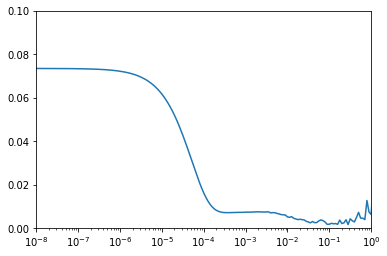

In [64]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.1])

In [65]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 2
batch_size = 1
shuffle_buffer_size = 10
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(4, input_shape=[None, 1]),
  #tf.keras.layers.Dense(12, activation='relu'),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-1, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(100,)
Epoch 1/500
98/98 [==============================] - 2s 24ms/step - loss: 0.0041 - mae: 0.0718
Epoch 2/500
98/98 [==============================] - 0s 3ms/step - loss: 0.0091 - mae: 0.1005
Epoch 3/500
98/98 [==============================] - 0s 3ms/step - loss: 0.0045 - mae: 0.0737
Epoch 4/500
98/98 [==============================] - 0s 3ms/step - loss: 0.0045 - mae: 0.0736
Epoch 5/500
98/98 [==============================] - 0s 3ms/step - loss: 0.0048 - mae: 0.0787
Epoch 6/500
98/98 [==============================] - 0s 3ms/step - loss: 0.0028 - mae: 0.0607
Epoch 7/500
98/98 [==============================] - 0s 3ms/step - loss: 0.0054 - mae: 0.0811
Epoch 8/500
98/98 [==============================] - 0s 3ms/step - loss: 0.0042 - mae: 0.0715
Epoch 9/500
98/98 [==============================] - 0s 3ms/step - loss: 0.0042 - mae: 0.0725
Epoch 10/500
98/98 [==============================] 

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [68]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast

array([[0.24922024],
       [0.2697649 ],
       [0.26533106],
       [0.25393838],
       [0.27427036],
       [0.2937165 ],
       [0.29274765],
       [0.27488357],
       [0.25119966],
       [0.23045987],
       [0.24878548],
       [0.2452778 ],
       [0.26084977],
       [0.28330502],
       [0.27379888],
       [0.25957316],
       [0.2957552 ],
       [0.32748145],
       [0.32395718],
       [0.30521342],
       [0.2699157 ],
       [0.24435888],
       [0.28188145],
       [0.28879288],
       [0.29608005],
       [0.340611  ],
       [0.31142676],
       [0.32849926],
       [0.33645523],
       [0.37017024],
       [0.36355385],
       [0.33906308],
       [0.30869922],
       [0.28829914],
       [0.32133767],
       [0.32632777],
       [0.3399548 ],
       [0.35938245],
       [0.33602762],
       [0.34248424],
       [0.40194926],
       [0.40909645],
       [0.42436844],
       [0.362634  ],
       [0.34701967],
       [0.32241285],
       [0.3632114 ],
       [0.360

In [0]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

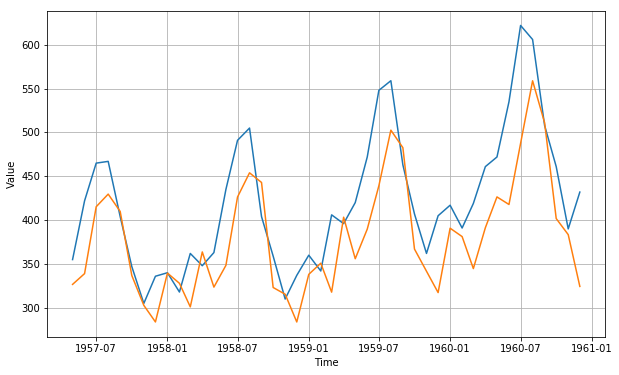

In [74]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid*622)
plot_series(time_valid, rnn_forecast*622)
plt.savefig('plot.png')
from google.colab import files
files.download("plot.png") 

In [73]:
from google.colab import files
files.download("plot.png") 

MessageError: ignored